In [1]:
import glob
import imageio

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython import display

from keras.datasets import mnist

import os

from PIL import Image

import time

In [2]:
# Getting the dataset

(X_train, Y_train), (_,_) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Now reshaping the images
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype("float32")

# Now standardizing the images between -1 and +1
X_train = (X_train-127.5)/127.5

In [4]:
# Define the sizes

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data

train_images = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
train_images

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [7]:
# Setting the noise for random images so that we can pass them to our Generator

noise = tf.random.normal([1,100])

In [8]:
print(noise)

tf.Tensor(
[[-0.193352    0.138962   -1.2696414  -1.6324345  -0.33833092 -0.20137118
   0.55463463 -0.32907033  0.31710318 -1.4192339  -0.82290685  0.35403576
  -1.0238558  -0.45812926 -0.09125751  0.60528475 -1.2932357   0.25289452
  -1.845144   -0.10873484  0.07254392 -0.34100503  0.9508659  -2.1127195
   1.5528638   0.37022865  0.3901775   1.0167373   0.16553108  2.6080685
   0.1789019  -0.19374079  0.6951685   0.11462074  0.56624424  0.8079683
   1.026614   -2.0364463  -0.8616166  -1.6138226  -1.7351264  -0.46996439
  -0.4155998  -0.57341826  1.0558218  -1.3911188  -0.8307117   0.7510239
  -1.6061063  -1.4715332   1.0948609   0.84195834 -0.51131505  0.9865244
   0.03209029  0.28271458 -0.9736235  -1.2120318   0.77574015 -0.17155012
   0.5212242  -0.17357814 -0.34651875  0.8032848   0.04476094  0.24460496
   0.32215065  0.55049485 -0.86188734 -1.8870585  -0.06578863 -3.4735835
   0.10373573  1.398217    1.3431284  -0.6597055  -0.19663258 -0.24134631
   2.1184442  -1.617564   -1.8897

# **Generator Model**

In [9]:
def generator_model():

  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, input_shape=(100,), use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None, 7,7,256)


  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False))
  assert model.output_shape==(None, 7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
  assert model.output_shape==(None, 14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation="tanh"))
  assert model.output_shape==(None, 28,28,1)

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


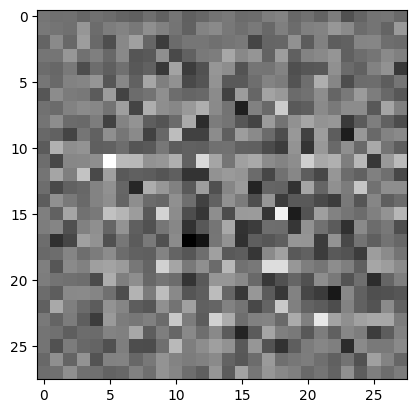

In [10]:
# Now passing random input to our model to see if it can generate an image (Untrained generator):-

generator = generator_model()

noise = tf.random.normal([1,100])
image = generator(noise, training=False)

plt.imshow(image[0,:,:,0], cmap="gray")

# **Discriminator Model**

In [11]:
def discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [12]:
# Use untrained discriminator to predict weather an image is fake or real

discriminator = discriminator_model()
decision = discriminator(image)
print(decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00027832]], shape=(1, 1), dtype=float32)


# **Loss and Optimizer**

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator Loss

In [14]:
def descriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

Generator Loss

In [15]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# **Optimizer**

In [16]:
# The Descriminator's and Generator's optimizers are different since we will train the two networks seperately.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **Saving the checkpoints of your model**

In [17]:
checkpoint_dir = "/.training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Defining the training loop

In [18]:
epochs = 100
noise_dim = 100
num_of_examples = 16

seed = tf.random.normal([num_of_examples, noise_dim])

In [19]:
# The purpose of this code is to update the parameters (weights and biases)
# of both the generator and the discriminator so that they improve their performance.

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Recording Operations for Gradient Calculation:
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      # Discriminator's predictions
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Calculating losses
      gen_loss = generator_loss(fake_output)
      disc_loss = descriminator_loss(real_output, fake_output)

    # Calculating Gradients:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Updating the Models and applying the gradients:
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
# Training process for a GAN, updating
# the generator and discriminator with each batch of data across multiple epochs.

def train(dataset, epochs):
  for epoch in range(epochs):
    start =time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Generating and Saving Images During Training:
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epoch,
                           seed)

# **Generate and Save Images**

In [21]:
# # Now explain me in simple words and in detail what we are doing here
# Notice `training` is set to False.
# This is so all layers run in inference mode (batchnorm).

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# **Training the model**

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

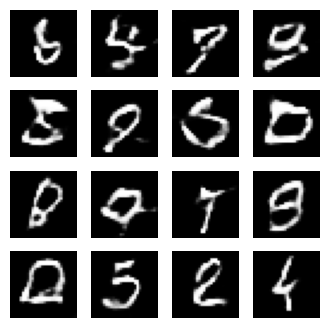

In [22]:
train(train_images, epochs)

In [23]:
# We so this cause above we trained and it takes a lot of time to do that
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

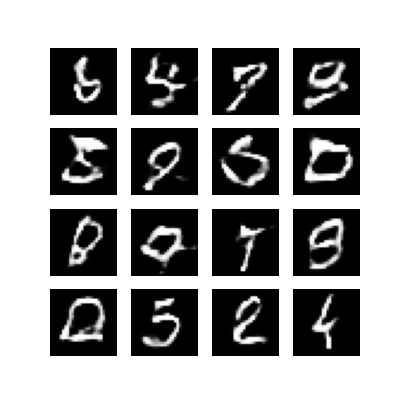

In [25]:
display_image(epochs)

# **Use imageio to create an animated gif using the images saved during training.**

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for i in filenames:
    image = imageio.imread(i)
    writer.append_data(image)
  image = imageio.imread(i)
  writer.append_data(image)

<ipython-input-26-146901a0c68c>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(i)
<ipython-input-26-146901a0c68c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(i)


In [29]:
!pip install tensorflow-docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 5.4 MB/s eta 0:00:00



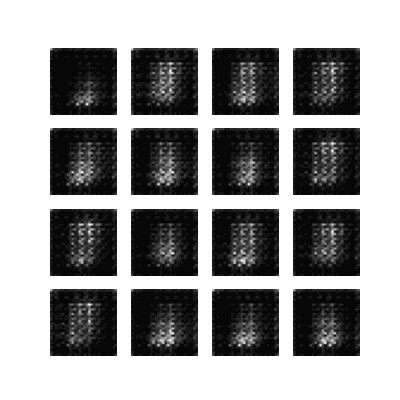

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)